### Useful links
[DIY-Drug-Discovery-using-molecular-fingerprints-and-machine-learning](http://moreisdifferent.com/2017/9/21/DIY-Drug-Discovery-using-molecular-fingerprints-and-machine-learning-for-solubility-prediction/)

[RDKit_Overview](http://www.rdkit.org/RDKit_Overview.pdf)

In [1]:
from collections import namedtuple

import pandas
import numpy
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR #import regression
from sklearn.metrics import mean_squared_error, r2_score

from rdkit import Chem
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [2]:
dataset_read = pandas.read_excel("dataset.xlsx")

# Trim Wang's (2015) predicted values since we are calculating these ourselves
dataset = dataset_read.iloc[:,0:4]
results = dataset_read.iloc[:,4:]

In [3]:
# From the main dataset, split into training and test dataframes
training_set = dataset.loc[dataset['Tr=traning set\nTe=test set'] == "Tr"]
test_set = dataset.loc[dataset['Tr=traning set\nTe=test set'] == "Te"]

print("Training set has {} items, test set has {} items".format(training_set.iloc[:,0].count(), test_set.iloc[:,0].count()))

Training set has 904 items, test set has 226 items


In [4]:
training_set.head()

,NO,Tr=traning set Te=test set,SMILES structure,experimental logD7.4
1,A-logD7.4-100,Tr,Fc1cc2c(N(C=C(C(O)=O)C2=O)C2CC2)cc1N1CCNCC1,-0.96
2,A-logD7.4-101,Tr,S1(=O)(=O)N(CCN1C)c1cc2c([nH]cc2CCN(C)C)cc1,-0.92
3,A-logD7.4-104,Tr,OC=1C(=O)C=CN(CCCO)C=1C,-0.90
4,A-logD7.4-105,Tr,Fc1cc2c(N(C=C(C(O)=O)C2=O)c2ccccc2C)cc1N1CCNCC1,-0.83
5,A-logD7.4-106,Tr,OC=1C(=O)C=CN(CCC(=O)NCC)C=1C,-0.82


## Fingerprinting molecules
    A way to encode and represent molecules in a format that 1) makes it easy to compare how similar or different two molecules 2) uniquely identify that molecule 3) allow for a quick and efficent search of the molecule's sub-structure.
    
    Fingerprinting is a technique traditionally used for molecule search and screening in large chemoinformatic databases, where many comparisons must be made a second. In this project, I'm hoping to use these techniques as a way to uniquely encode a molecule in a way that is easy to feed into a ML algorithm while also retaining the specific features/descriptors of that molecule which may contribute to its lipophillicity.

    Essentially a hash.

#### Quick bit on fingerprints vs structural keys
    "A fingerprint is a boolean array, or bitmap, but unlike a structural key there is no assigned meaning to each bit. Your own fingerprint is very characteristic of you, yet there is no meaning to any particular feature. Similarly, a pattern's fingerprint characterizes the pattern, but the meaning of any particular bit is not well defined... In spite of the difference between the meaning of a fingerprint's bits and a structural key's bits, fingerprints share an important feature with structural keys: If a pattern is a substructure of a molecule, every bit that is set in the pattern's fingerprint will be set in the molecule's fingerprint."
        
[Source](http://www.daylight.com/dayhtml/doc/theory/theory.finger.html)

### Which fingerprint should I use?
    Good q, just gonna pick one and run with it. I'll come back to see if theres a better fitting one later.
[Possible source](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf)
 

## Experiment with RDKit on single molecule

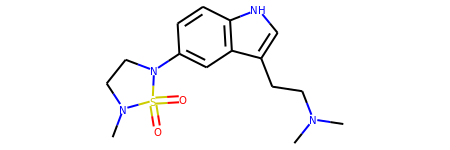

In [5]:
# taking SMILE from `training_set['SMILES structure'].iloc[1]`, creating a molecule object
molecule = Chem.MolFromSmiles('S1(=O)(=O)N(CCN1C)c1cc2c([nH]cc2CCN(C)C)cc1')
# Lets generate a rdk fingerprint from the molecule, which is really a DataStructs.ExplicitBitVect
RDK_fp = RDKFingerprint(molecule, fpSize=512)
# Draw the molecule
molecule

## Back to working with training_set

In [6]:
xytuple = namedtuple('xytuple', ['x', 'y'])

def df_to_xy(df):
    ### return numpy of arrays
    # Make an arr of lipophillicity values
    lip_arr = df['experimental logD7.4'].values
    # Make an arr of fingerprints
    mol_series = df['SMILES structure'].apply(Chem.MolFromSmiles)
    RDK_fp_series = mol_series.apply(lambda mol: numpy.array(RDKFingerprint(mol, fpSize=512)))
    RDK_fp_arr = numpy.matrix(RDK_fp_series.tolist())
    return xytuple(x=RDK_fp_arr, y=lip_arr)
    

In [7]:
### Prepare training set and test set to feed into ml algo
x_train, y_train = df_to_xy(training_set)
x_test, y_test = df_to_xy(test_set)

## Simple linear regression

r squared:
So, in our model,-81.69% of the variability in Y can be explained using X. 
-----
Linear Regression RMSE:
Our model was able to predict the value of every lipo in the test set within 2.27 of the real lipo.
-----
MSE train: 0.39
MSE test: 5.16
we are an average 5.16 away from the ground truth when making predictions on our test set.


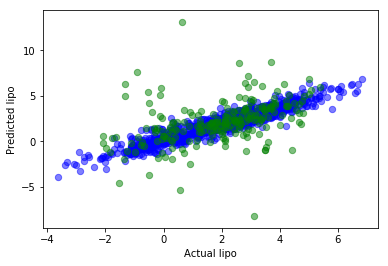

Data not randomly dispered and has structure, need to adjust linear regression model


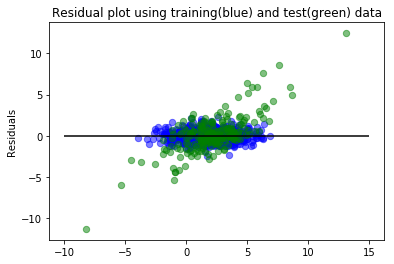

In [8]:
model = LinearRegression()
model.fit(x_train, y_train)

# predict on the unseen dataset
y_pred_train = model.predict(x_train)
y_pred = model.predict(x_test)

# R-squared is a goodness-of-fit measubre for linear regression models, how much variance of the data vs our model
# Explained variance score: 1 is perfect prediction
print("r squared:")
print('So, in our model,{:.2f}% of the variability in Y can be explained using X. '.format(model.score(x_test, y_test)*100))
###NEGATIVE R2??? Come back to fix
print("-----")
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = numpy.sqrt(lin_mse)

print('Linear Regression RMSE:')
print('Our model was able to predict the value of every lipo in the test set within {:.2f} of the real lipo.'.format(lin_rmse))
print("-----")

# We want a low mse
print("MSE train: {:.2f}".format(mean_squared_error(y_pred_train, y_train)))
print("MSE test: {:.2f}".format(mean_squared_error(y_pred, y_test)))
print("we are an average {:.2f} away from the ground truth when making predictions on our test set.".format(mean_squared_error(y_pred, y_test)))
# Data is overfit

# Plot outputs training data
plt.scatter(y_train, y_pred_train, c='b',s=40, alpha=.5)
# Plot outputs test data
plt.scatter(y_test,y_pred, c='g',s=40, alpha=.5)
plt.xlabel("Actual lipo")
plt.ylabel("Predicted lipo")
plt.show()

plt.scatter(model.predict(x_train), model.predict(x_train)-y_train, c='b',s=40, alpha=.5)
plt.scatter(model.predict(x_test), model.predict(x_test)-y_test, c='g',s=40, alpha=.5)
plt.hlines(y=0, xmin=-10, xmax=15)
plt.title("Residual plot using training(blue) and test(green) data")
plt.ylabel("Residuals")
print("Data not randomly dispered and has structure, need to adjust linear regression model")

Seem to be struggling with linear models, lets try SVM?

### SVM Regression

R^2 Score :
So, in our model, 65.24% of the variability in Y can be explained using X. 
-----
SVM RMSE:
Our model was able to predict the value of every lipo in the test set within 0.99 of the real lipo.
-----
MSE train: 0.07
MSE test: 0.99
We are an average 0.99 away from the ground truth when making predictions on our test set.
Check to see if overfit


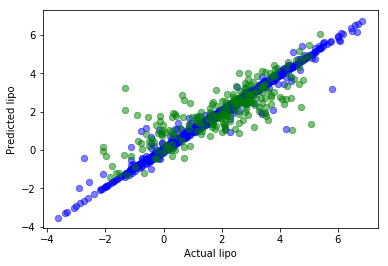

Data somewhat dispered structure, model looks ok


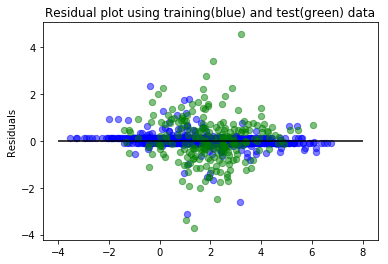

In [9]:
model = SVR(
    ## tune hyperparams
    kernel='rbf', 
    C=10, #regularization parameter, smaller values are larger margins
    gamma = .01, # small val -> include far data points, large -> only those close to margin
)
model.fit(x_train, y_train)
# predict on the unseen dataset
y_pred_train = model.predict(x_train)
y_pred = model.predict(x_test)

# R-squared is a goodness-of-fit measubre for regression models, how much variance of the data vs our model
# Explained variance score: 1 is perfect prediction
print("R^2 Score :")
print('So, in our model, {:.2f}% of the variability in Y can be explained using X. '.format(model.score(x_test, y_test)*100))
print("-----")
svm_mse = mean_squared_error(y_pred, y_test)
svm_rmse = numpy.sqrt(svm_mse)

print('SVM RMSE:')
print('Our model was able to predict the value of every lipo in the test set within {:.2f} of the real lipo.'.format(svm_rmse))
print("-----")

# We want a low mse
print("MSE train: {:.2f}".format(mean_squared_error(y_pred_train, y_train)))
print("MSE test: {:.2f}".format(mean_squared_error(y_pred, y_test)))
print("We are an average {:.2f} away from the ground truth when making predictions on our test set.".format(mean_squared_error(y_pred, y_test)))
if(mean_squared_error(y_pred_train, y_train)*2 < mean_squared_error(y_pred, y_test)):
    print("Check to see if overfit")
# Plot outputs training data
plt.scatter(y_train, y_pred_train,c='b',s=40, alpha=.5)
# Plot outputs test data
plt.scatter(y_test,y_pred, c='g',s=40, alpha=.5)
plt.xlabel("Actual lipo")
plt.ylabel("Predicted lipo")
plt.show()

plt.scatter(model.predict(x_train), model.predict(x_train)-y_train, c='b',s=40, alpha=.5)
plt.scatter(model.predict(x_test), model.predict(x_test)-y_test, c='g',s=40, alpha=.5)
plt.hlines(y=0, xmin=-4,xmax=8)
plt.title("Residual plot using training(blue) and test(green) data")
plt.ylabel("Residuals")
print("Data somewhat dispered structure, model looks ok")

In [10]:
#Testing one molecule
### return numpy of arrays
actual_lip = [-0.92]
molecule = Chem.MolFromSmiles('S1(=O)(=O)N(CCN1C)c1cc2c([nH]cc2CCN(C)C)cc1')
# Lets generate a rdk fingerprint from the molecule, which is really a DataStructs.ExplicitBitVect
RDK_fp = RDKFingerprint(molecule, fpSize=512)
RDK_fp = numpy.matrix(numpy.array(RDK_fp))
model.predict(RDK_fp)


array([-0.81998869])